# TO·Pi·cks:

## Forecast Consumer-Interest in Topics

__Author: Tarun Gupta  
  Company: Insight Data Science  
  Location: Toronto, ON__   
  Date: Januray 2019  
  Github: https://github.com/tguptaMT/TOPicks  
  __About:__ Powered by NLP and machine-learning based time-series forecasting, TO·Pi·cks is a consumer-engagement and popularity forecasting tool. See ReadMe file for more details. 
  
  _This is the __third__ file in a series of Jupyter notebooks associated with TOPicks._

### Step3: Time-Series Forecasting of Topic Popularity and Consumer-Interest:

- __Load Data:__ 
    - load NLP-processed data with engineered features and topics assigned to the corpus from Step2 along with popularity and engagement metrics.
- __ Time-series pre-processing:__
    - Select relevant features
    - Normalize datetime data by day to aggregate hourly posts.
    - Downsample by weekly medians as I am primarily interested in predicting future weeks.
    - Remove miscellenous topic cluster #0
    - Explore data distribution over the years:
        - Examine trend, seasonality and residual distribution by decomposition
        - Choose between manually optimizing AR MA terms through ACF/PACF plots, ADF tests etc. or transforming the time-series data into a sequential regression problem for Ensemble-ML methods.
- __Feature Engineering:__    
    - Create proxy to time-series data:
        - Add lag terms
        - Month of the year
        - Week of the year
- __Comparative Forecasting:__
    - VIF Multicollinearity assessment across clusters
    - Ridge Regression: with engineered temporal features + exogenous variables
- __Ensemble ML approaches to forecasting: Wisdom of the Crowds__
    - Random forests: unoptimized
    - Gradient Boosting: unoptimized
    - Compare RMSE with persistence model and dMASE: % improvement in MASE compared to baseline
- __Hyper-parameter tuning:__
    - Parameter GridSearch + walk-forward validation for Random Forests (SLOW)
    - Parameter GridSearch + walk-forward validation for Gradient Boosting (VERY SLOW)
- __Explore Alternatives:__
    - Hard gridsearch for ARIMA terms with automated seasonality estimation with PSD and gridsearch on fourier terms
    - Deep learning: LSTM in Keras 

In [67]:
import os
import re
import glob
import sqlite3
import datetime
import random
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from joblib import dump, load
import pyarrow
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

# Models:
from sklearn.linear_model import Ridge
import lightgbm as lgb
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error


#### Define Functions

In [87]:
#################### TIME SERIES RELATED FUNCTIONS ####################

def ts_preprocess(data, ntopic, metric, sampling, view_corr=False):
    """
    Input: 
        data: timeseries dataframe
        ntopic: topic identifier
        metric: facebook likes / comments counts
        sampling: Weekly: ['W-MON'], Daily: ['D], Monthly: ['M]
        view_corr: examine spearman correlation matrix.
    
    Function: Preprocess time-series data by -
        1. filter df by topic
        2. Summerize the metric over the day and robust averaging over the week.
        3. Adding lag1 and lag2 for the metric of interst.
        4. Generate temporal features: month and week of the year.
        
    Output: engineered df
    Author: Tarun Gupta, Insight Data Science, Toronto, ON
    """
    X = data[data['predicted_topic'] == ntopic]
    X = X.drop(columns=['predicted_topic'])
    X = X.groupby('date').sum()
    X = X.resample('W-MON').median()
    # X[str(metric)+'_count'] = outlier2median(X[str(metric)+'_count'], n_std=5)
                                # Outlier detection not required as:
                                # a) I am already working with series resampled by median, and
                                # b) Voting methods like RF or GB are robust to outliers.
                
    X['Last_Week_'+str(metric)] = X[str(metric)+'_count'].shift()
    X['Last_Week_Diff'] = X['Last_Week_'+str(metric)].diff()
    X['Last_2Week_'+str(metric)] = X[str(metric)+'_count'].shift(2)
    X['Last_2Week_Diff'] = X['Last_2Week_'+str(metric)].diff()
    X = X.reset_index(drop=False)
    X['monthofyear'] = X.date.dt.month
    X['weekofyear'] = X.date.dt.weekofyear
    X = X.dropna()
    X.set_index('date', drop=True, inplace=True)
    
    if view_corr:
        corr = X.corr(method='spearman')
        # Display negative corr: red, positive corr: green
        display(corr.mask(corr==1).style\
         .bar(align='mid', color=['#d65f5f', '#5fba7d'])\
         .format("{:.2f}"))
    return X

#--------------------------------------------------------#

def cal_errors(val, base_preds, model_preds):
    """
    Input: 
        val = validation or test data,
        base_preds = predictions made by naive/baseline model
        base_model = predictions made by model of interest
    Function:
        Calculates RMSE and modified MASE for baseline and test model.
        MASE: Mean average scaled error: MAE_model/MAE_base   
        dMASE: (MAE_base-MAE_model)/MAE_base i.e. percent improvement in MAE
                relative to the basline model.
    """
    rmse_base = np.sqrt(mean_squared_error(val, base_preds))
    mae_base = mean_absolute_error(val, base_preds)
    rmse_model = np.sqrt(mean_squared_error(val, model_preds))
    mae_model = mean_absolute_error(val, model_preds)
    dmase = round((mae_base-mae_model)/mae_base, 3)
    return rmse_base, rmse_model, dmase
    
#--------------------------------------------------------#

def ts_ensemble(X, model_name, model_params, ntopic, metric='likes', plot_=False, verbose=True):
    """
    Input:
        *Processed DataFrame returned by ts_preprocess()* <- This is important.
        ntopic: predicted topic number from NMF modeling.
        metric: facebook likes or comments counts
        sampling: Weekly: ['W-MON'], Daily: ['D], Monthly: ['M]
        model_params: gridsearch optimized params or default params if not optimized
        Plot_: Boolean
        
    Description: 
        Fits selected model against the persistence model as Baseline. 
        Model options: Ridge regression, Random Forests, Gradient Boosting (with or withou hyp-param tuning.)
        Persitence model: Today is same as yesterday. Tomorrow will be same as today.
    
    Output: Prediction errors returned by cal_errors() 
            Plot of baseline and gradient boosted predicteds against validation.
    Author: Tarun Gupta, Insight Data Science, Toronto, ON        
    """
    
    temp_pred_df = pd.DataFrame()
    # define model params:
    if model_name =='rr':
        model = Ridge()
    elif model_name =='gb':
        model = LGBMRegressor()
    elif model_name == 'rf':
        model = RandomForestRegressor()
        
    # Set model params (either default or through ParameterGrid)
    model.set_params(**model_params)
    
    # define interim data collection containers 
    all_validation, all_preds_base, all_preds_model = [], [], []
    
    # Set up Walk-forward validation with a 80:20 split:
    for week in range(round(X.shape[0]*0.8), len(X)):
        train = X.iloc[:week]
        validation = pd.DataFrame(X.iloc[week]).T
        validation.columns = X.columns
        
        ######## Baseline | Persistence ########
        preds_base = validation['Last_Week_'+str(metric)]  

        all_validation.append(validation[str(metric)+'_count'])
        all_preds_base.append(preds_base)
        
        ######## Ensemble Models ########
        xtr, xts = train.drop([str(metric)+'_count'], axis=1), validation.drop([str(metric)+'_count'], axis=1)
        ytr, yts = train[str(metric)+'_count'], validation[str(metric)+'_count']
        
        model.fit(xtr, ytr)
        preds_model = model.predict(xts)
        all_preds_model.append(preds_model)
    
        validation.loc[:, 'preds_'+str(metric)+'_'+str(model_name)] = np.round(preds_model, 4)
        validation.loc[:, 'predicted_topic'] = ntopic
        temp_pred_df= temp_pred_df.append(validation)  # temporarily store predictions
                                                       # on validation set
        
    ######## Calculate errors ########
    rmse_base, rmse_model, dmase = cal_errors(all_validation, all_preds_base, all_preds_model)
    if verbose:
        print("Topic: {}, Base RMSE: {}, {} Model RMSE: {}, dMASE: {}".
          format(ntopic, rmse_base, model_name.upper(), rmse_model, dmase))
    
    if plot_:
        # Plot predicted and actual counts:
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        x = np.arange(len(all_validation))
        colors = ["red", "blue", "amber"]
        sns.set_palette(sns.xkcd_palette(colors))
        axes.plot(x, all_preds_model, '--', label='Prediction')
        axes.plot(x, all_validation, '-', label='Actual')
        axes.plot(x, all_preds_base, '--', label='Baseline (lag1)')
        axes.set_title('Weekly '+model_name.upper()+' Predictions against Persistence/Baseline Model (lag1)\
        \nWalk-Forward Validation: 80:20 split')
        axes.set_xlabel("Weeks")
        if metric == 'likes':
            axes.set_ylabel("Median Popularity: Topic# {}".format(ntopic))
        else:
            axes.set_ylabel("Median User Engagement")
        axes.legend()
        plt.show()
    return temp_pred_df, rmse_base, rmse_model, dmase

#--------------------------------------------------------#

def model_hp_tuning(X, model_name, ntopic, metric='likes', grid_frac=0.33, verbose=False):
    """
    Function: Hyperparameter tuning for gradient boosting.
    Inputs:
        *Processed DataFrame returned by ts_preprocess()* <- This is important.
        model_name: Gradient boosting (gb) or Random Forests (rf)
        ntopic: predicted topic number from NMF modeling.
        metric: facebook likes or comments counts
        grid_frac: fraction of the grid to sample randomly. Default: 1/3rd. 
        verbose: Boolean (only recommended for live grid performance tracking)
    Note: This takes a LONG time to run on a typical macbook CPU. 
          GPU or cloud services preferred. If these services are not available,
          consider reducing the number of parameters.
    Author: Tarun Gupta, Insight Data Science, Toronto, ON
    """
    if model_name == 'gb':
        grid = {
            "num_leaves":[25],
            "min_data_in_leaf":[10, 20, 30],
            "metric":['mae'],
            "max_depth":[3,5,8, None],
            "learning_rate": [0.001, 0.003, 0.01, 0.025, 0.05, 0.1],
            "n_estimators":[100, 500, 750, 1000]}

    elif model_name == 'rf':
        grid = {
            'max_features': ['auto'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            "max_depth":[3, 5, 7, None],
            "n_estimators":[100, 250, 500, 750, 1000]}         
    else:
        print("Model name not specified. Options: 'gb' or 'rf'")
        pass
    
    best_rmse = float('inf')
    
    grid_iters = round(grid_frac*len(ParameterGrid(grid)))  # Number of grids to randomly sample.
    print("Tuning hyperparameters for {}. Randomly sampling {} grids..".format(
                                            model_name.upper(), grid_iters))
    for g in np.random.choice(list(ParameterGrid(grid)), size=grid_iters, replace=False, p=None):
        _, rmse_base, rmse_model, dmase = ts_ensemble(
                        X, model_name, g, ntopic, metric, plot_=False, verbose=False)
        if verbose:
            print("Topic: {}, dMASE: {}\n Grid: {}".format(ntopic, dmase, g))

        if rmse_model < best_rmse:
            best_rmse, best_dmase, best_grid,  = rmse_model, dmase, g

    print("\nTopic: {}, {} Best RMSE: {}, Best dMASE: {}\t Grid: {}".\
          format(ntopic, model_name.upper(), best_rmse, best_dmase, best_grid))

    return best_grid

#--------------------------------------------------------#

def outlier2median(ts, n_std=5):
    """
    Function: removes extreme outliers
    Input: 
        - Pandas Series
        - deviation from median: default: 5*st. dev away in either direction)
    Output: Median imputed series for extreme outliers. 
    """
    median= ts.median()
    std = np.std(ts)
    for i in range(len(ts)):
        if ((ts[i] < median-(n_stdev*std)) or (ts[i] > median+(n_stdev*std))):
            ts[x] = median
    return ts

#--------------------------------------------------------#

def comp_ts_modelling(model_name, model_tuning, data, grid_frac=0.33, plot_freq=25):
    """
    Function: Comparative time-series Modelling
    Model_name: options -
        - Persistence = Baseline: Tomorrow will be same as today.
        - RR (ridge regression)
        - GB (gradient boosting)
        - RF (Random Forests)
        - ARIMA
        - LSTM
    Model_tuning: Boolean (True for hyperparameter gridsearch: VERY SLOW)
    Data: DF with assigned topics from step 2.
    plot_freq: Plot every 25th model fit (in case of large number of models)
               Change to 1 if you'd like to plot every model fit.
    Author: Tarun Gupta, Insight Data Science, Toronto, ON
    """

    # Containers for storing performance metrics for all topics
    tmp_topic, tmp_model_params = [], []
    tmp_dmase, tmp_rmse_base, tmp_rmse_model  = [], [], []
    all_predictions = pd.DataFrame()

    # Time-series modeling for all topics
    alltopics = data['predicted_topic'].unique()
    alltopics = sorted(alltopics, reverse=True)
    for ntopic in alltopics:
        try:
            # Prepare data and engineer lag for timeseries analysis:
            X = ts_preprocess(data, ntopic, metric='likes', sampling='W-MON', view_corr=False)
            
            if model_tuning: # Hyperparameter search:
                    model_params = model_hp_tuning(X, model_name, ntopic, metric='likes', 
                                                   grid_frac=grid_frac, verbose=False)
            else: # default parameters
                if model_name == 'rr':
                    model_params = {'alpha': 0.5, 'normalize':True}
                
                elif model_name == 'gb':
                    model_params = {'n_estimators':1000, 'learning_rate':0.001}
                    
                elif model_name == 'rf':
                    model_params = {'n_estimators':1000, 'n_jobs':-1, 'random_state':1}
                
                elif model_name == 'arima':
                    # ts_model = model_arima()
                    print("ARIMA will be made available soon.")
                    break

                elif model_name == 'lstm':
                    # ts_model = model_lstm()
                    print("LSTM will be made available soon.")
                    break

                else:
                    print("Model not selected.")
                    break

            # Switch plotting on for every nth topic fit:
            if ntopic in list(range(1, max(alltopics), plot_freq)):
                plot_ = True
            else:
                plot_ = False

            # Fit model:
            temp_pred_df, rmse_base, rmse_model, dmase = \
                                ts_ensemble(X, model_name, model_params, 
                                ntopic=ntopic, metric='likes', plot_=plot_)

            # Concatenate (row-wise) predicted values df for each topic 
            all_predictions = pd.concat([all_predictions, temp_pred_df],axis=0, ignore_index=False)

            # Collect summary data for all topics
            tmp_topic.append(ntopic)
            tmp_rmse_base.append(rmse_base)
            tmp_rmse_model.append(rmse_model)
            tmp_dmase.append(dmase)
            tmp_model_params.append(model_params)

        except IndexError:
            print(ntopic ," not found in the collection of topics")
            pass

    # Create a summary df for all performance metrics
    summary_df = pd.DataFrame()
    summary_df['ntopic'] = tmp_topic
    summary_df['rmse_base'] = tmp_rmse_base
    summary_df['rmse_model'] = tmp_rmse_model
    summary_df['dmase'] = tmp_dmase
    summary_df['model'] = model_name
    summary_df['hp_tuning'] = str(model_tuning)
#     summary_df['model_params'] = str(tmp_model_params) 

    # Save predictions and prediction metrics to file:
    fname = str(model_name)+'_hptuning='+str(model_tuning)+\
            '_nmf_ntopics='+str(round(len(data['predicted_topic'].unique())))
    summary_df.to_parquet('data/ts_predictions/pred_summary_ts_'+fname+'.parquet', engine='pyarrow')

    all_predictions.to_parquet('data/ts_predictions/all_preds_ts_'+fname+'.parquet', engine='pyarrow')

    # Save all predictions to JSON for compatbility with Tableau if needed.
    all_predictions.reset_index(drop=False).to_json('data/ts_predictions/all_preds_ts_'+fname+'.json', orient='index')

    return summary_df, all_predictions


### Load Topic-Modelled Data: 

In [4]:
# import data containing topic assignments from Step2:
pq_name = 'data/parquet_data/step2_NMF_topics=200_assigned.parquet'
pilot = pd.read_parquet(pq_name, engine='pyarrow')
all_topics = pilot['topic_name'].unique()

### Time Series Analysis

In [53]:
# Select only relevant columns
data = pilot.filter(regex=r'date|predicted_topic|likes_count|\
                      |num_all_words|%_caps')

# Select last 4 years of data (2013-2017 end)
data = data.query('20130101 < date')

# Select topics other than topic 0:
data = data.query('predicted_topic != 0.0')

# Normalize datetime objects by day  
data.date = pd.to_datetime(data['date'], unit = 'd')
data.date = data.date.dt.normalize() + datetime.timedelta(days=1)

data.sort_values('date').head(5)

,date,likes_count,num_all_words,%_caps,predicted_topic
153776,2013-01-02,396,6,19.35,130
313668,2013-01-02,223,9,21.95,96
139722,2013-01-02,59,10,4.44,27
201061,2013-01-02,759,8,5.71,66
77394,2013-01-02,115,5,18.52,165


In [54]:
# Check for nan values
data.isna().sum()

date               0
likes_count        0
num_all_words      0
%_caps             0
predicted_topic    0
dtype: int64

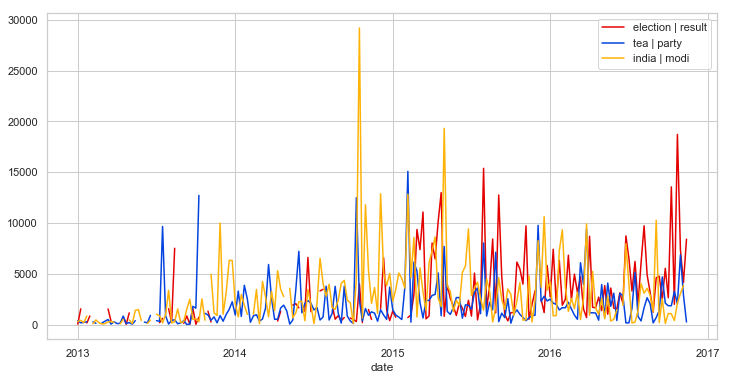

In [58]:
# What do some of these time-series look like?
## Examine Distrbution of 3 random topic's popularity over time:

sns.set(style="whitegrid")
colors = ["red", "blue", "amber"]
sns.set_palette(sns.xkcd_palette(colors))
plt.figure(figsize=(12, 6))
for nt in random.sample(range(1, 199), 3):
    data[data.predicted_topic == nt].set_index('date').\
        likes_count.resample('W-MON').mean().plot(label=all_topics[nt], legend=True)
plt.show()


There certainly are temporal structures in the data. We can decompose data to examine seasonality, trend and residual distribution:

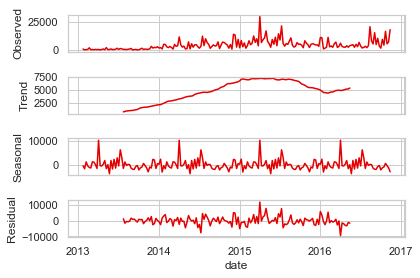

In [59]:
Xts = ts_preprocess(data, 1, 'likes', 'W-MON', view_corr=False)
Xts = Xts['likes_count'].resample('W-MON').sum()
result = seasonal_decompose(Xts, model='additive')
result.plot();

There's certainly seasonality in the data. Decomposing all 200 time-series for manual examination combined with ACF/PACF plots to determine order of differencing or the appropriate AR MA terms may not be the best use of my time given the limited time within which I need to deploy this model.

If I really wanted to do ARIMA/SARIMAX, the best way to do that on 200 different time-series might be to do a random gridsearch along with Augmented Dickey Fuller test to establish differencing. Combined with walk-forward validation of each pqd combination, that'll take a LONG time even on the colab GPU. Other option is to estimate seasonality automatically with power spectrum density (PSD) and estimating the number of fourier terms as exogenous regressors in ARIMA. In contrast, even the unoptimized ensemble methods like RF or GB tend to work reasonably well out of the box with some feature engineering if the time-series problem is transformed to a regression problem-space. Alternatively, deep learning (LSTM) can also be explored for this task.

For now, I'll __start with a simple regression model and see how it performs.__

### Comparative Modelling:

#### Select Type of Regression

* Use a __linear regression and not negative binomial__ regresssion as I'd be running regression against weekly *median* counts (not the actual count data) which is a continuous variable. If I were to use y=weekly total count, than it might be more appropriate to use NB2.

#### Are the predictor variables correlated?

In [60]:
X_eda = ts_preprocess(data=data, ntopic=1, metric='likes', sampling='W-MON', view_corr=True);

,likes_count,num_all_words,%_caps,Last_Week_likes,Last_Week_Diff,Last_2Week_likes,Last_2Week_Diff,monthofyear,weekofyear
likes_count,nan,0.69,0.41,0.57,-0.04,0.59,0.02,0.08,0.06
num_all_words,0.69,nan,0.61,0.52,0.01,0.50,0.06,-0.03,-0.04
%_caps,0.41,0.61,nan,0.20,0.04,0.20,0.07,-0.19,-0.19
Last_Week_likes,0.57,0.52,0.20,nan,0.39,0.58,-0.05,0.06,0.08
Last_Week_Diff,-0.04,0.01,0.04,0.39,nan,-0.45,-0.51,-0.05,-0.02
Last_2Week_likes,0.59,0.50,0.20,0.58,-0.45,nan,0.38,0.07,0.06
Last_2Week_Diff,0.02,0.06,0.07,-0.05,-0.51,0.38,nan,-0.03,-0.03
monthofyear,0.08,-0.03,-0.19,0.06,-0.05,0.07,-0.03,nan,0.94
weekofyear,0.06,-0.04,-0.19,0.08,-0.02,0.06,-0.03,0.94,nan


#### Check Severity of Multicollinearity with Variance Inflation Factor (VIF):


$$VIF_k = \frac{1}{1-R^2_k}$$


__VIF__ is a measure of how much the variance of the estimated regression coefficient is "inflated" by the existence of correlation among the predictor variables. A VIF of 1 means that there is no correlation among the kth predictor and the remaining predictor variables, and hence the variance for that coefficient is not inflated. Generally, VIFs >4 warrant further investigation, while VIFs >10 are signs of serious multicollinearity requiring correction.

In [61]:
# Check VIF for all 200 clusters:
alltopics = data['predicted_topic'].unique()
alltopics = sorted(alltopics, reverse=True)
vif_df = pd.DataFrame()
for ntopic in alltopics:
    X_eda = ts_preprocess(data=data, ntopic=ntopic, metric='likes', sampling='W-MON', view_corr=False);
    X_eda = X_eda.drop(columns=['likes_count']).assign(const=1) # Statsmodels VIF needs a constant in the features df 
    vif_df = vif_df.append(pd.DataFrame([variance_inflation_factor(X_eda.values, i) 
                                         for i in range(X_eda.shape[1])], index=X_eda.columns).T, ignore_index=True)
vif_df.drop(columns=['const']).head()

,num_all_words,%_caps,Last_Week_likes,Last_Week_Diff,Last_2Week_likes,Last_2Week_Diff,monthofyear,weekofyear
0,1.562052,1.549117,inf,inf,inf,1.926277,13.640274,13.660220
1,1.893302,1.850906,inf,inf,inf,1.949239,7.989599,8.012344
2,1.360790,1.359441,inf,inf,inf,1.507525,7.887378,7.952949
3,2.949069,2.935239,inf,inf,inf,2.005367,12.102055,12.239857
4,3.347016,3.259375,inf,inf,inf,1.979961,7.381776,7.446458


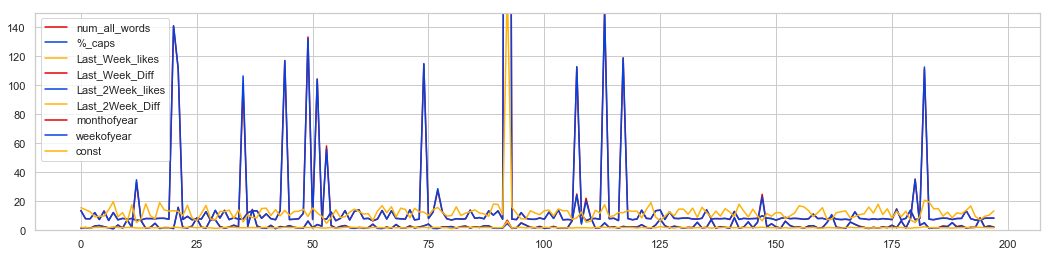

In [64]:
vif_df.plot(figsize=(18, 4), ylim=(0, 150))

As there aren't a whole lot of features to select but there's severe multicollearity (VIF>10) within some of the features, it's appropriate to use __Ridge regression__ in this case. Another option is doing a PCA to impose orthogonality amongst components but I'd like to retain the original interpretation of the features in this case so that I can derive post-hoc actionable insights.

### Ridge regression

Topic: 199, Base RMSE: 2741.1964812192227, RR Model RMSE: 2493.0998898042253, dMASE: -0.132
Topic: 198, Base RMSE: 3441.7245778017223, RR Model RMSE: 3005.746015431741, dMASE: 0.155
Topic: 197, Base RMSE: 10339.734669118825, RR Model RMSE: 6732.742669690584, dMASE: 0.296
Topic: 196, Base RMSE: 2561.5181344713933, RR Model RMSE: 2125.1823899051274, dMASE: -0.139
Topic: 195, Base RMSE: 2077.1111979312586, RR Model RMSE: 1917.3015281753449, dMASE: -0.03
Topic: 194, Base RMSE: 4589.537378647221, RR Model RMSE: 5236.497232004121, dMASE: -0.498
Topic: 193, Base RMSE: 1823.2674594176874, RR Model RMSE: 1344.8517184054779, dMASE: 0.272
Topic: 192, Base RMSE: 1914.3017825087372, RR Model RMSE: 1391.7687251967095, dMASE: 0.194
Topic: 191, Base RMSE: 6397.575985078136, RR Model RMSE: 3038.598445384825, dMASE: 0.343
Topic: 190, Base RMSE: 6872.445236327154, RR Model RMSE: 5221.944287286462, dMASE: 0.106
Topic: 189, Base RMSE: 25088.11687443989, RR Model RMSE: 14099.22088617046, dMASE: 0.492
Topic:

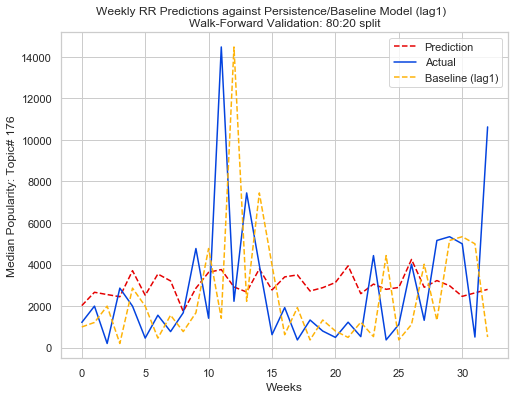

Topic: 175, Base RMSE: 1492.0789162856777, RR Model RMSE: 2121.3980245113326, dMASE: -1.084
Topic: 174, Base RMSE: 10368.47316736502, RR Model RMSE: 4589.758210431879, dMASE: 0.473
Topic: 173, Base RMSE: 3440.095321399176, RR Model RMSE: 2794.1718059277805, dMASE: 0.063
Topic: 172, Base RMSE: 4537.237423740788, RR Model RMSE: 3231.011206742041, dMASE: 0.252
Topic: 171, Base RMSE: 3288.3619307339027, RR Model RMSE: 2550.897179219912, dMASE: 0.048
Topic: 170, Base RMSE: 1636.849177099536, RR Model RMSE: 1394.2606948569833, dMASE: 0.212
Topic: 169, Base RMSE: 3960.4949659101953, RR Model RMSE: 2936.621958320921, dMASE: 0.114
Topic: 168, Base RMSE: 1890.328450697167, RR Model RMSE: 2212.758542058135, dMASE: -0.438
Topic: 167, Base RMSE: 3049.4737695918243, RR Model RMSE: 2091.3833300078823, dMASE: 0.044
Topic: 166, Base RMSE: 3480.1550146043314, RR Model RMSE: 3890.958683397458, dMASE: -0.162
Topic: 165, Base RMSE: 1589.8014324419873, RR Model RMSE: 1635.8512783616954, dMASE: -0.139
Topic:

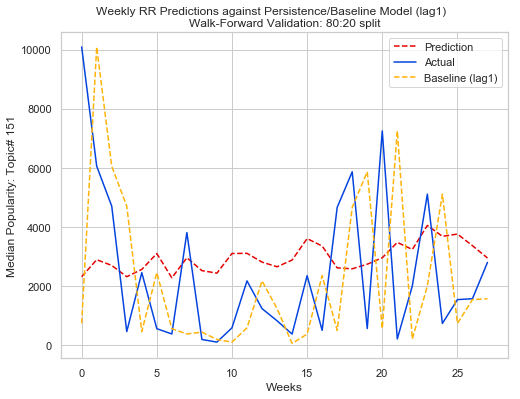

Topic: 150, Base RMSE: 1180.2559044546229, RR Model RMSE: 892.1665166939719, dMASE: 0.23
Topic: 149, Base RMSE: 2962.0071673545053, RR Model RMSE: 1902.80706967212, dMASE: 0.288
Topic: 148, Base RMSE: 4446.950500061812, RR Model RMSE: 5274.036310321928, dMASE: -0.65
Topic: 147, Base RMSE: 2757.483382590575, RR Model RMSE: 3045.5965630187548, dMASE: -0.045
Topic: 146, Base RMSE: 32906.64260583622, RR Model RMSE: 26485.677819767996, dMASE: 0.163
Topic: 145, Base RMSE: 6740.862736065064, RR Model RMSE: 4072.033472523228, dMASE: 0.333
Topic: 144, Base RMSE: 3136.3543556077007, RR Model RMSE: 2197.971733109132, dMASE: 0.358
Topic: 143, Base RMSE: 5301.315312613465, RR Model RMSE: 3534.226691975556, dMASE: 0.171
Topic: 142, Base RMSE: 3602.0112128889573, RR Model RMSE: 2601.772863882651, dMASE: 0.318
Topic: 141, Base RMSE: 4888.41382122054, RR Model RMSE: 3333.2814322128306, dMASE: 0.286
Topic: 140, Base RMSE: 5111.491241627564, RR Model RMSE: 3155.960165366568, dMASE: 0.198
Topic: 139, Base

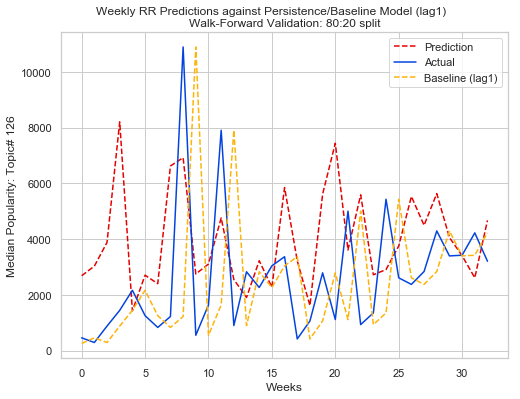

Topic: 125, Base RMSE: 3833.902949811253, RR Model RMSE: 2274.0603091422727, dMASE: 0.367
Topic: 124, Base RMSE: 3657.1729428376134, RR Model RMSE: 3195.9181955732106, dMASE: -0.092
Topic: 123, Base RMSE: 10445.45781637885, RR Model RMSE: 4840.600730177054, dMASE: 0.441
Topic: 122, Base RMSE: 3197.0460324076244, RR Model RMSE: 3392.2238667605657, dMASE: -0.328
Topic: 121, Base RMSE: 4105.692067283097, RR Model RMSE: 4940.47139058437, dMASE: -0.808
Topic: 120, Base RMSE: 1583.8447102467055, RR Model RMSE: 1192.9529514180656, dMASE: 0.242
Topic: 119, Base RMSE: 3075.4702848463635, RR Model RMSE: 2143.455398331913, dMASE: 0.277
Topic: 118, Base RMSE: 4158.630832907841, RR Model RMSE: 2668.086868477428, dMASE: 0.32
Topic: 117, Base RMSE: 1874.227399798073, RR Model RMSE: 1608.2605277637783, dMASE: -0.056
Topic: 116, Base RMSE: 6168.701121612051, RR Model RMSE: 3550.5263873623335, dMASE: 0.496
Topic: 115, Base RMSE: 3666.378992178211, RR Model RMSE: 1923.0154853995405, dMASE: 0.389
Topic: 1

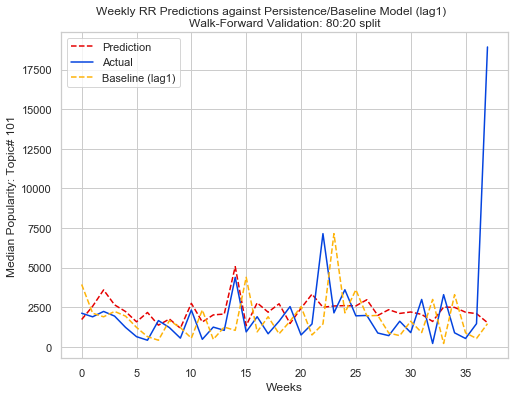

Topic: 100, Base RMSE: 4296.991584542792, RR Model RMSE: 3306.188353728607, dMASE: 0.172
Topic: 99, Base RMSE: 6908.796807007196, RR Model RMSE: 4961.010356800191, dMASE: 0.188
Topic: 98, Base RMSE: 2498.8579857123977, RR Model RMSE: 2136.666664796144, dMASE: 0.025
Topic: 97, Base RMSE: 2437.9156200148723, RR Model RMSE: 2291.735239964067, dMASE: 0.123
Topic: 96, Base RMSE: 4233.612201928253, RR Model RMSE: 2699.8951790545148, dMASE: 0.255
Topic: 95, Base RMSE: 1581.1703229816128, RR Model RMSE: 1280.6199026289557, dMASE: 0.031
Topic: 94, Base RMSE: 3727.2365354477397, RR Model RMSE: 2996.9705536023725, dMASE: 0.165
Topic: 93, Base RMSE: 4561.823346322779, RR Model RMSE: 2955.8623706143558, dMASE: 0.184
Topic: 92, Base RMSE: 4064.3450886951023, RR Model RMSE: 2644.7487343883327, dMASE: 0.292
Topic: 91, Base RMSE: 2135.8965086898133, RR Model RMSE: 2706.267634442448, dMASE: -0.232
Topic: 90, Base RMSE: 3234.4988351034717, RR Model RMSE: 2241.965703209126, dMASE: 0.393
Topic: 89, Base RM

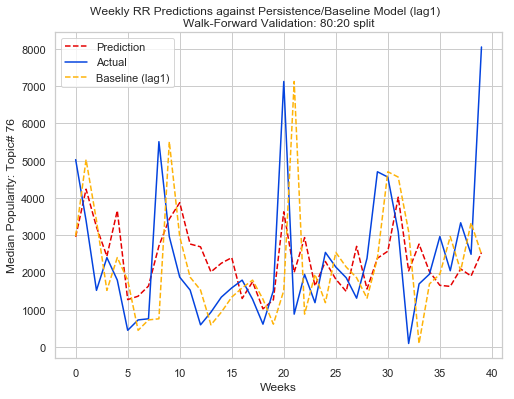

Topic: 75, Base RMSE: 2602.340702589294, RR Model RMSE: 1747.0186526987247, dMASE: 0.317
Topic: 74, Base RMSE: 14505.86846737751, RR Model RMSE: 10970.181246453489, dMASE: 0.19
Topic: 73, Base RMSE: 13375.11027442171, RR Model RMSE: 13138.96777868173, dMASE: 0.074
Topic: 72, Base RMSE: 1775.026917300934, RR Model RMSE: 1984.1190149712759, dMASE: -0.041
Topic: 71, Base RMSE: 5339.763547426444, RR Model RMSE: 3526.5793825544665, dMASE: 0.347
Topic: 70, Base RMSE: 4331.708742310028, RR Model RMSE: 3147.441561787592, dMASE: 0.165
Topic: 69, Base RMSE: 2958.834791657744, RR Model RMSE: 1821.3135606422866, dMASE: 0.329
Topic: 68, Base RMSE: 1936.1743561725013, RR Model RMSE: 1179.8534122178544, dMASE: 0.251
Topic: 67, Base RMSE: 2502.024854351945, RR Model RMSE: 2238.7429947696232, dMASE: 0.15
Topic: 66, Base RMSE: 2857.7088625080655, RR Model RMSE: 3181.858462241756, dMASE: 0.148
Topic: 65, Base RMSE: 3609.9804227693226, RR Model RMSE: 2812.213563399764, dMASE: 0.246
Topic: 64, Base RMSE: 5

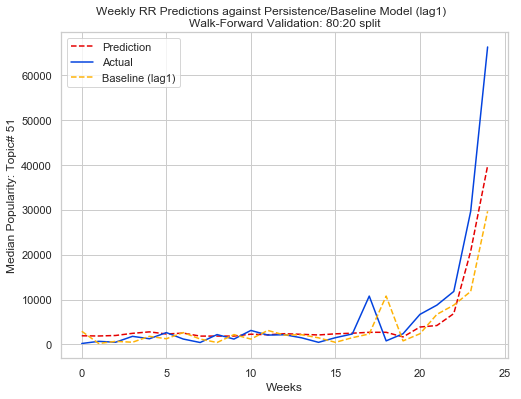

Topic: 50, Base RMSE: 3122.060959926952, RR Model RMSE: 2269.102935257492, dMASE: 0.216
Topic: 49, Base RMSE: 3341.112764775299, RR Model RMSE: 3875.463409129256, dMASE: -0.059
Topic: 48, Base RMSE: 2603.924830339544, RR Model RMSE: 1878.8355954272597, dMASE: 0.193
Topic: 47, Base RMSE: 4157.044050425673, RR Model RMSE: 3411.6080740403277, dMASE: -0.066
Topic: 46, Base RMSE: 2722.434852669027, RR Model RMSE: 2006.1569389046151, dMASE: 0.126
Topic: 45, Base RMSE: 8154.461896441287, RR Model RMSE: 4985.293652125966, dMASE: 0.389
Topic: 44, Base RMSE: 5204.815919550879, RR Model RMSE: 3910.7321245257876, dMASE: 0.261
Topic: 43, Base RMSE: 3361.620653948424, RR Model RMSE: 2669.830224309115, dMASE: 0.117
Topic: 42, Base RMSE: 4671.867987545834, RR Model RMSE: 4526.127063168228, dMASE: -0.083
Topic: 41, Base RMSE: 2126.1969684418023, RR Model RMSE: 1741.6034514242772, dMASE: 0.099
Topic: 40, Base RMSE: 2421.6524849912953, RR Model RMSE: 1858.2635034847133, dMASE: 0.199
Topic: 39, Base RMSE:

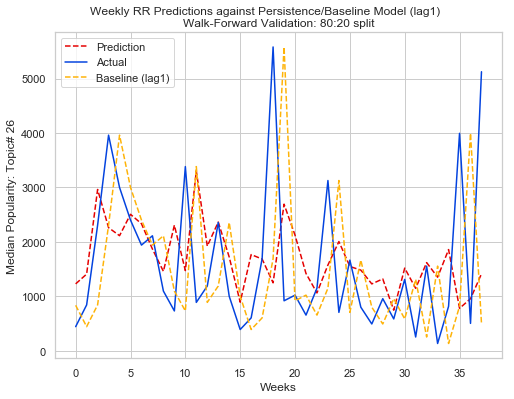

Topic: 25, Base RMSE: 2939.1553275513843, RR Model RMSE: 1905.991092520543, dMASE: 0.306
Topic: 24, Base RMSE: 3463.186799342891, RR Model RMSE: 2386.136512248168, dMASE: 0.158
Topic: 23, Base RMSE: 3539.616537888549, RR Model RMSE: 2486.025908331976, dMASE: 0.301
Topic: 22, Base RMSE: 3484.7334433285755, RR Model RMSE: 2307.124726944374, dMASE: 0.171
Topic: 21, Base RMSE: 3903.3361712290425, RR Model RMSE: 2949.997152244802, dMASE: 0.186
Topic: 20, Base RMSE: 3338.372918566926, RR Model RMSE: 2225.087391927018, dMASE: 0.27
Topic: 19, Base RMSE: 4453.250712445319, RR Model RMSE: 3380.1606176551554, dMASE: 0.192
Topic: 18, Base RMSE: 2434.9782215440737, RR Model RMSE: 3043.422905815988, dMASE: -0.342
Topic: 17, Base RMSE: 3566.2837082178416, RR Model RMSE: 2229.8082221783716, dMASE: 0.305
Topic: 16, Base RMSE: 11859.338770212556, RR Model RMSE: 6664.857077274454, dMASE: 0.261
Topic: 15, Base RMSE: 2629.7632202528416, RR Model RMSE: 2800.715691017166, dMASE: -0.196
Topic: 14, Base RMSE: 

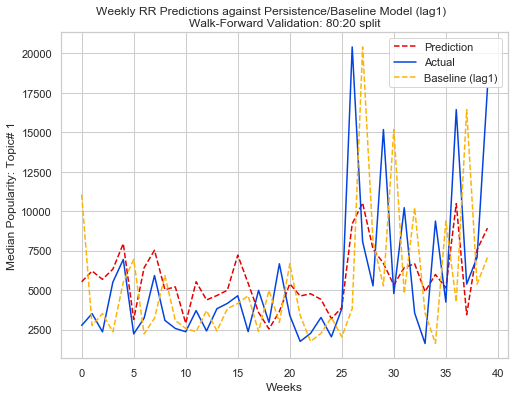

In [88]:
# Unoptimized Ridge regression:
# alpha: 0.05 --> dMase: 20.539
# alpha = 0.5 --> dMase: 24.416

alpha_rr = 0.5
summary_df, all_predictions = comp_ts_modelling(model_name='rr', model_tuning=False, 
                                                data=data, grid_frac=0, plot_freq=25)

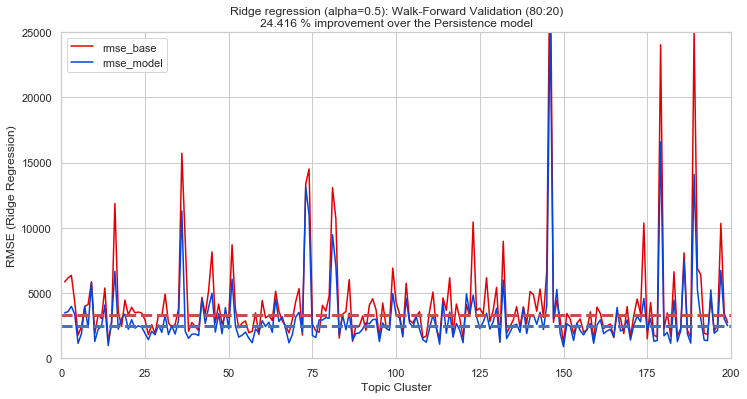

In [89]:
ax = plt.subplot(111)
summary_df.set_index('ntopic')[['rmse_base', 'rmse_model']]\
                    .plot(ax=ax, logy=False, ylim=(0, 25000),
                         figsize=(12, 6), xlim=(0,200))
    
rbase = summary_df['rmse_base'].median()
rmodel = summary_df['rmse_model'].median()
plt.plot([0, 200], [rbase, rbase], 'r--', lw=3)
plt.plot([0, 200], [rmodel, rmodel], 'b--', lw=3)
plt.xlabel("Topic Cluster")
plt.ylabel('RMSE (Ridge Regression)')
title = 'Ridge regression (alpha='+str(alpha_rr)+'): Walk-Forward Validation (80:20)\n'+ str(round(((summary_df.rmse_base - summary_df.rmse_model)/\
      summary_df.rmse_base).median()*100, 3))+' % improvement over the Persistence model'
plt.title(title);

### Wisdom of the Crowds: Random Forests

Topic: 199, Base RMSE: 2741.1964812192227, RF Model RMSE: 2444.652390741559, dMASE: -0.033
Topic: 198, Base RMSE: 3441.7245778017223, RF Model RMSE: 3176.068711163757, dMASE: 0.127
Topic: 197, Base RMSE: 10339.734669118825, RF Model RMSE: 6859.849676930541, dMASE: 0.269
Topic: 196, Base RMSE: 2561.5181344713933, RF Model RMSE: 2387.0590778568235, dMASE: -0.238
Topic: 195, Base RMSE: 2077.1111979312586, RF Model RMSE: 2638.5001136726305, dMASE: -0.041
Topic: 194, Base RMSE: 4589.537378647221, RF Model RMSE: 7759.654191553707, dMASE: -0.493
Topic: 193, Base RMSE: 1823.2674594176874, RF Model RMSE: 1458.6125546902047, dMASE: 0.2
Topic: 192, Base RMSE: 1914.3017825087372, RF Model RMSE: 1731.073800541386, dMASE: 0.031
Topic: 191, Base RMSE: 6397.575985078136, RF Model RMSE: 3093.326953940862, dMASE: 0.301
Topic: 190, Base RMSE: 6872.445236327154, RF Model RMSE: 5153.721179260619, dMASE: 0.09
Topic: 189, Base RMSE: 25088.11687443989, RF Model RMSE: 14973.875917063458, dMASE: 0.425
Topic: 18

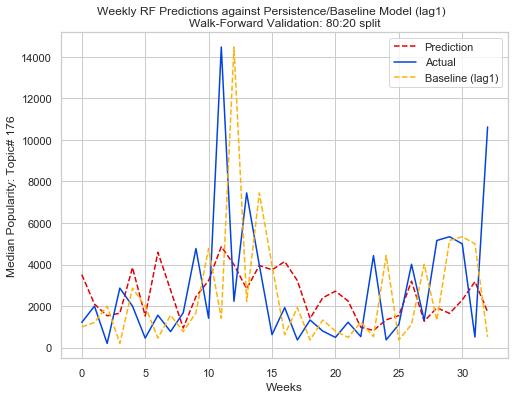

Topic: 175, Base RMSE: 1492.0789162856777, RF Model RMSE: 4469.311059674216, dMASE: -2.018
Topic: 174, Base RMSE: 10368.47316736502, RF Model RMSE: 6535.675175672001, dMASE: 0.413
Topic: 173, Base RMSE: 3440.095321399176, RF Model RMSE: 2914.624152340839, dMASE: -0.012
Topic: 172, Base RMSE: 4537.237423740788, RF Model RMSE: 4047.6634449936005, dMASE: 0.046
Topic: 171, Base RMSE: 3288.3619307339027, RF Model RMSE: 2506.759132812484, dMASE: 0.124
Topic: 170, Base RMSE: 1636.849177099536, RF Model RMSE: 1208.6041204544042, dMASE: 0.33
Topic: 169, Base RMSE: 3960.4949659101953, RF Model RMSE: 3367.9617398288806, dMASE: 0.011
Topic: 168, Base RMSE: 1890.328450697167, RF Model RMSE: 2784.476861554192, dMASE: -0.429
Topic: 167, Base RMSE: 3049.4737695918243, RF Model RMSE: 2344.2706378544085, dMASE: -0.02
Topic: 166, Base RMSE: 3480.1550146043314, RF Model RMSE: 3958.58982951518, dMASE: -0.124
Topic: 165, Base RMSE: 1589.8014324419873, RF Model RMSE: 1775.984215232491, dMASE: -0.261
Topic: 1

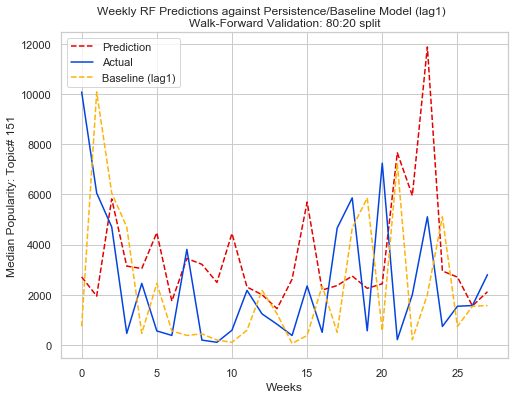

Topic: 150, Base RMSE: 1180.2559044546229, RF Model RMSE: 974.6478439927741, dMASE: 0.169
Topic: 149, Base RMSE: 2962.0071673545053, RF Model RMSE: 1897.8976502853898, dMASE: 0.256
Topic: 148, Base RMSE: 4446.950500061812, RF Model RMSE: 2911.408212912879, dMASE: -0.026
Topic: 147, Base RMSE: 2757.483382590575, RF Model RMSE: 3083.3040976737534, dMASE: -0.11
Topic: 146, Base RMSE: 32906.64260583622, RF Model RMSE: 26521.417280654983, dMASE: 0.311
Topic: 145, Base RMSE: 6740.862736065064, RF Model RMSE: 6371.078404183291, dMASE: 0.103
Topic: 144, Base RMSE: 3136.3543556077007, RF Model RMSE: 2274.121062140544, dMASE: 0.293
Topic: 143, Base RMSE: 5301.315312613465, RF Model RMSE: 4162.889074909819, dMASE: 0.131
Topic: 142, Base RMSE: 3602.0112128889573, RF Model RMSE: 2771.0099386594916, dMASE: 0.204
Topic: 141, Base RMSE: 4888.41382122054, RF Model RMSE: 3848.171623316471, dMASE: 0.128
Topic: 140, Base RMSE: 5111.491241627564, RF Model RMSE: 6777.888880835468, dMASE: -0.031
Topic: 139, 

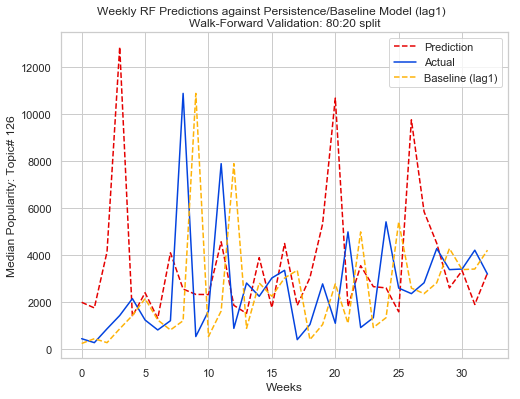

Topic: 125, Base RMSE: 3833.902949811253, RF Model RMSE: 2325.329065320135, dMASE: 0.358
Topic: 124, Base RMSE: 3657.1729428376134, RF Model RMSE: 3148.400177284773, dMASE: 0.055
Topic: 123, Base RMSE: 10445.45781637885, RF Model RMSE: 6806.609770115798, dMASE: 0.275
Topic: 122, Base RMSE: 3197.0460324076244, RF Model RMSE: 3802.8930047543417, dMASE: -0.348
Topic: 121, Base RMSE: 4105.692067283097, RF Model RMSE: 3854.2221889173325, dMASE: -0.048
Topic: 120, Base RMSE: 1583.8447102467055, RF Model RMSE: 1581.8102127306247, dMASE: -0.023
Topic: 119, Base RMSE: 3075.4702848463635, RF Model RMSE: 2304.14030892318, dMASE: 0.27
Topic: 118, Base RMSE: 4158.630832907841, RF Model RMSE: 3046.430859222161, dMASE: 0.235
Topic: 117, Base RMSE: 1874.227399798073, RF Model RMSE: 1662.1974858665762, dMASE: -0.057
Topic: 116, Base RMSE: 6168.701121612051, RF Model RMSE: 3661.386600611981, dMASE: 0.408
Topic: 115, Base RMSE: 3666.378992178211, RF Model RMSE: 2253.6173689857837, dMASE: 0.319
Topic: 114

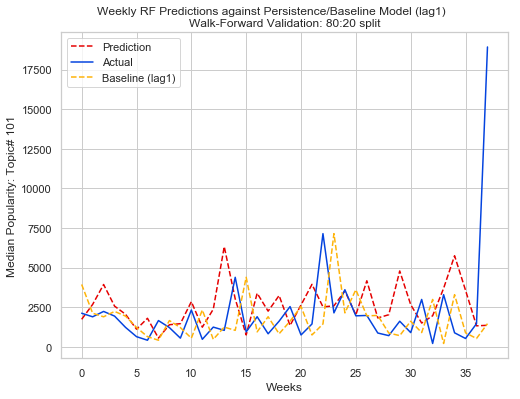

Topic: 100, Base RMSE: 4296.991584542792, RF Model RMSE: 3930.2757271901132, dMASE: 0.077
Topic: 99, Base RMSE: 6908.796807007196, RF Model RMSE: 5906.926658890587, dMASE: -0.007
Topic: 98, Base RMSE: 2498.8579857123977, RF Model RMSE: 2598.7325494190995, dMASE: -0.099
Topic: 97, Base RMSE: 2437.9156200148723, RF Model RMSE: 2396.502379378334, dMASE: -0.031
Topic: 96, Base RMSE: 4233.612201928253, RF Model RMSE: 3223.9850464264828, dMASE: 0.13
Topic: 95, Base RMSE: 1581.1703229816128, RF Model RMSE: 1263.0295840007982, dMASE: 0.101
Topic: 94, Base RMSE: 3727.2365354477397, RF Model RMSE: 3276.3336209925615, dMASE: 0.087
Topic: 93, Base RMSE: 4561.823346322779, RF Model RMSE: 3331.5110783230402, dMASE: 0.187
Topic: 92, Base RMSE: 4064.3450886951023, RF Model RMSE: 3480.782834925495, dMASE: 0.172
Topic: 91, Base RMSE: 2135.8965086898133, RF Model RMSE: 1164.331593062061, dMASE: 0.458
Topic: 90, Base RMSE: 3234.4988351034717, RF Model RMSE: 2122.1607428441994, dMASE: 0.425
Topic: 89, Base

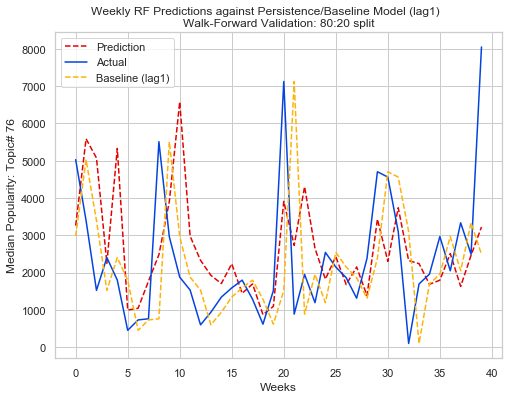

Topic: 75, Base RMSE: 2602.340702589294, RF Model RMSE: 1867.060664546909, dMASE: 0.269
Topic: 74, Base RMSE: 14505.86846737751, RF Model RMSE: 11023.78284291123, dMASE: 0.232
Topic: 73, Base RMSE: 13375.11027442171, RF Model RMSE: 13243.972405139597, dMASE: 0.038
Topic: 72, Base RMSE: 1775.026917300934, RF Model RMSE: 3176.941053850341, dMASE: -0.533
Topic: 71, Base RMSE: 5339.763547426444, RF Model RMSE: 3327.3787251266053, dMASE: 0.405
Topic: 70, Base RMSE: 4331.708742310028, RF Model RMSE: 3472.3219320113185, dMASE: 0.139
Topic: 69, Base RMSE: 2958.834791657744, RF Model RMSE: 2067.876717017546, dMASE: 0.244
Topic: 68, Base RMSE: 1936.1743561725013, RF Model RMSE: 1541.6299035751172, dMASE: 0.051
Topic: 67, Base RMSE: 2502.024854351945, RF Model RMSE: 2379.2768650298444, dMASE: 0.085
Topic: 66, Base RMSE: 2857.7088625080655, RF Model RMSE: 3091.915158556921, dMASE: 0.139
Topic: 65, Base RMSE: 3609.9804227693226, RF Model RMSE: 2433.513400745286, dMASE: 0.308
Topic: 64, Base RMSE: 5

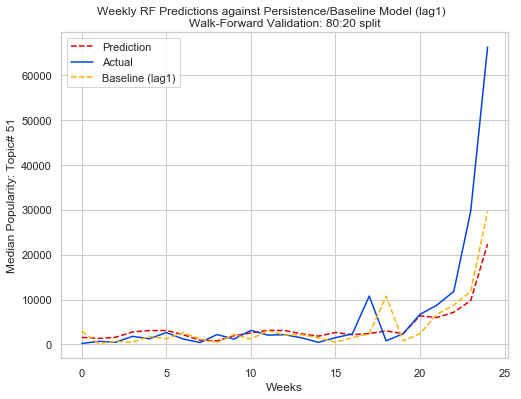

Topic: 50, Base RMSE: 3122.060959926952, RF Model RMSE: 2432.7827525976477, dMASE: 0.16
Topic: 49, Base RMSE: 3341.112764775299, RF Model RMSE: 5667.747405382548, dMASE: -0.376
Topic: 48, Base RMSE: 2603.924830339544, RF Model RMSE: 2209.382824116678, dMASE: 0.051
Topic: 47, Base RMSE: 4157.044050425673, RF Model RMSE: 4639.963820543646, dMASE: -0.461
Topic: 46, Base RMSE: 2722.434852669027, RF Model RMSE: 2471.417167050723, dMASE: 0.026
Topic: 45, Base RMSE: 8154.461896441287, RF Model RMSE: 4909.029206128399, dMASE: 0.34
Topic: 44, Base RMSE: 5204.815919550879, RF Model RMSE: 6761.12515622203, dMASE: -0.117
Topic: 43, Base RMSE: 3361.620653948424, RF Model RMSE: 3115.71216517872, dMASE: 0.053
Topic: 42, Base RMSE: 4671.867987545834, RF Model RMSE: 5343.277951271658, dMASE: -0.277
Topic: 41, Base RMSE: 2126.1969684418023, RF Model RMSE: 2144.1781650363037, dMASE: -0.084
Topic: 40, Base RMSE: 2421.6524849912953, RF Model RMSE: 1822.2557912414184, dMASE: 0.219
Topic: 39, Base RMSE: 2738

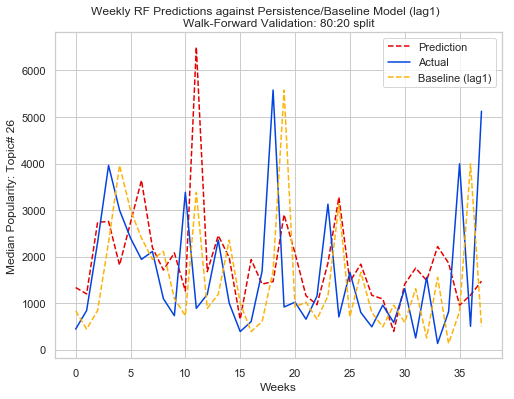

Topic: 25, Base RMSE: 2939.1553275513843, RF Model RMSE: 1940.741075113905, dMASE: 0.343
Topic: 24, Base RMSE: 3463.186799342891, RF Model RMSE: 2890.9023437207034, dMASE: -0.008
Topic: 23, Base RMSE: 3539.616537888549, RF Model RMSE: 2660.8543432258775, dMASE: 0.248
Topic: 22, Base RMSE: 3484.7334433285755, RF Model RMSE: 3317.893761059636, dMASE: -0.052
Topic: 21, Base RMSE: 3903.3361712290425, RF Model RMSE: 2826.0277180857547, dMASE: 0.279
Topic: 20, Base RMSE: 3338.372918566926, RF Model RMSE: 2312.330530330951, dMASE: 0.241
Topic: 19, Base RMSE: 4453.250712445319, RF Model RMSE: 3467.65317500758, dMASE: 0.12
Topic: 18, Base RMSE: 2434.9782215440737, RF Model RMSE: 3215.1259001275234, dMASE: -0.268
Topic: 17, Base RMSE: 3566.2837082178416, RF Model RMSE: 3140.6703425493624, dMASE: 0.119
Topic: 16, Base RMSE: 11859.338770212556, RF Model RMSE: 7877.92039545653, dMASE: 0.211
Topic: 15, Base RMSE: 2629.7632202528416, RF Model RMSE: 3760.0648137671237, dMASE: -0.388
Topic: 14, Base RM

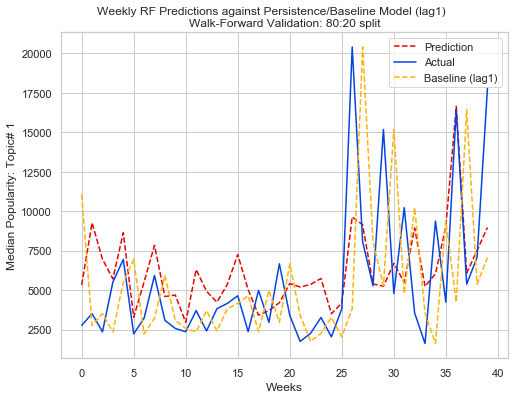

In [90]:
# Unoptimized Random Forests:
summary_df, all_predictions = comp_ts_modelling(model_name='rf', model_tuning=False, 
                                                data=data, grid_frac=0, plot_freq=25)

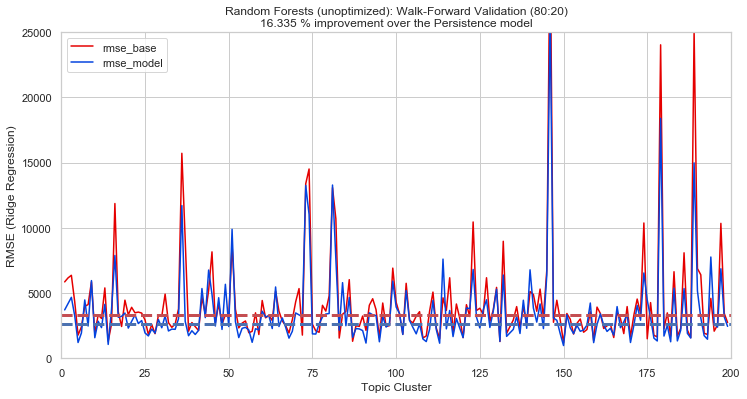

In [91]:
ax = plt.subplot(111)
summary_df.set_index('ntopic')[['rmse_base', 'rmse_model']]\
                    .plot(ax=ax, logy=False, ylim=(0, 25000),
                         figsize=(12, 6), xlim=(0,200))
    
rbase = summary_df['rmse_base'].median()
rmodel = summary_df['rmse_model'].median()
plt.plot([0, 200], [rbase, rbase], 'r--', lw=3)
plt.plot([0, 200], [rmodel, rmodel], 'b--', lw=3)
plt.xlabel("Topic Cluster")
plt.ylabel('RMSE (Ridge Regression)')
title = 'Random Forests (unoptimized): Walk-Forward Validation (80:20)\n'+ str(round(((summary_df.rmse_base - summary_df.rmse_model)/\
      summary_df.rmse_base).median()*100, 3))+' % improvement over the Persistence model'
plt.title(title);

There's some improvement in RMSE (15.85%) by unoptimized random forests over 200 topic clusters when compared to the baseline persistence model but the performance improvement is marginal at best. Some of the fits were way off although they did seem to estimate the general direction of the movement. Let's see how gradient boosting does out of the box:

#### Gradient Boosting (lgbm)

Topic: 199, Base RMSE: 2726.1167895011395, GB Model RMSE: 2408.4365804360164, dMASE: -0.052
Topic: 198, Base RMSE: 3280.2121324917907, GB Model RMSE: 2770.546230302292, dMASE: 0.205
Topic: 197, Base RMSE: 9620.807654072847, GB Model RMSE: 6618.16349962296, dMASE: 0.245
Topic: 196, Base RMSE: 2501.0863753862754, GB Model RMSE: 2057.0022187532563, dMASE: -0.035


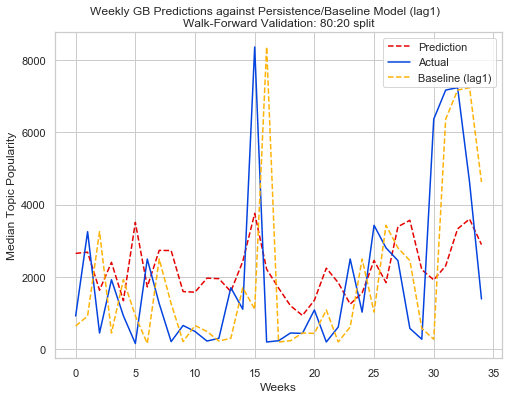

Topic: 195, Base RMSE: 2246.8284056899815, GB Model RMSE: 1639.7208886174176, dMASE: 0.198
Topic: 194, Base RMSE: 4589.537378647221, GB Model RMSE: 4600.894757993577, dMASE: -0.386
Topic: 193, Base RMSE: 1896.3138601237827, GB Model RMSE: 1299.2188835858155, dMASE: 0.32
Topic: 192, Base RMSE: 1914.3017825087372, GB Model RMSE: 1517.9752927197683, dMASE: 0.134
Topic: 191, Base RMSE: 7033.387803896498, GB Model RMSE: 5069.161922462569, dMASE: 0.21
Topic: 190, Base RMSE: 6626.721976855268, GB Model RMSE: 4991.906603488397, dMASE: 0.142
Topic: 189, Base RMSE: 23529.40171100933, GB Model RMSE: 16089.29272708948, dMASE: 0.461
Topic: 188, Base RMSE: 1537.6596552156066, GB Model RMSE: 1244.7399579403323, dMASE: 0.012
Topic: 187, Base RMSE: 2127.1611657323947, GB Model RMSE: 2192.416081019448, dMASE: -0.491
Topic: 186, Base RMSE: 7954.313075307006, GB Model RMSE: 6586.128237192146, dMASE: 0.195
Topic: 185, Base RMSE: 2195.3802420029074, GB Model RMSE: 1853.1953801518414, dMASE: 0.165
Topic: 184

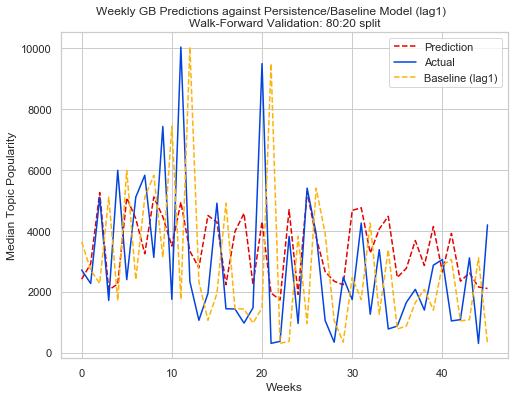

Topic: 180, Base RMSE: 2268.869525777099, GB Model RMSE: 1760.031492727814, dMASE: 0.091
Topic: 179, Base RMSE: 22116.809555554497, GB Model RMSE: 15671.495335581909, dMASE: 0.292
Topic: 178, Base RMSE: 1639.4576117940853, GB Model RMSE: 1317.113381779256, dMASE: 0.146
Topic: 177, Base RMSE: 1669.5280271182432, GB Model RMSE: 1174.6633514321588, dMASE: 0.218
Topic: 176, Base RMSE: 4397.369904941174, GB Model RMSE: 3048.070492568182, dMASE: 0.238
Topic: 175, Base RMSE: 1482.7235403885047, GB Model RMSE: 3140.0076408722134, dMASE: -1.491
Topic: 174, Base RMSE: 10077.682932024061, GB Model RMSE: 7373.024469893593, dMASE: 0.413
Topic: 173, Base RMSE: 3260.4858331882156, GB Model RMSE: 2405.903315067942, dMASE: 0.192
Topic: 172, Base RMSE: 4237.7670184463395, GB Model RMSE: 3200.647554757471, dMASE: 0.141
Topic: 171, Base RMSE: 3501.1430673107, GB Model RMSE: 2661.9007324788936, dMASE: 0.134
Topic: 170, Base RMSE: 1593.3259528750743, GB Model RMSE: 1539.5085780005804, dMASE: 0.124
Topic: 16

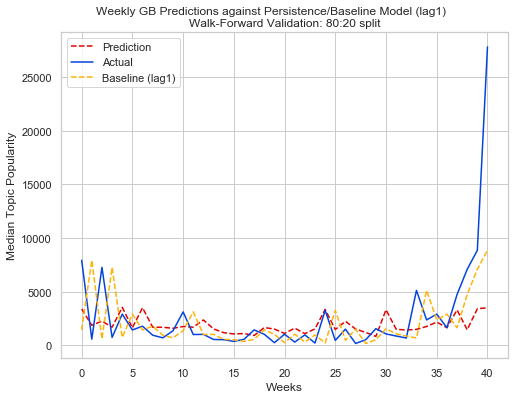

Topic: 165, Base RMSE: 1694.8161404707002, GB Model RMSE: 1391.9569966886222, dMASE: 0.114
Topic: 164, Base RMSE: 2631.57178367446, GB Model RMSE: 3268.292962076901, dMASE: -0.625
Topic: 163, Base RMSE: 2407.993890891634, GB Model RMSE: 1897.425584093953, dMASE: 0.177
Topic: 162, Base RMSE: 2419.517053222261, GB Model RMSE: 2080.763151306167, dMASE: 0.018
Topic: 161, Base RMSE: 3457.038959723714, GB Model RMSE: 2694.081007800866, dMASE: 0.208
Topic: 160, Base RMSE: 3745.2208057364164, GB Model RMSE: 2405.010815773843, dMASE: 0.257
Topic: 159, Base RMSE: 1289.8452401702089, GB Model RMSE: 1061.7813168375, dMASE: 0.015
Topic: 158, Base RMSE: 6010.172971720531, GB Model RMSE: 4020.8262254629485, dMASE: 0.26
Topic: 157, Base RMSE: 2099.658904002718, GB Model RMSE: 1900.8207577214787, dMASE: -0.031
Topic: 156, Base RMSE: 1986.0373648635482, GB Model RMSE: 1682.1884515858499, dMASE: -0.036
Topic: 155, Base RMSE: 2803.6687616407185, GB Model RMSE: 1962.5639316053364, dMASE: 0.344
Topic: 154, 

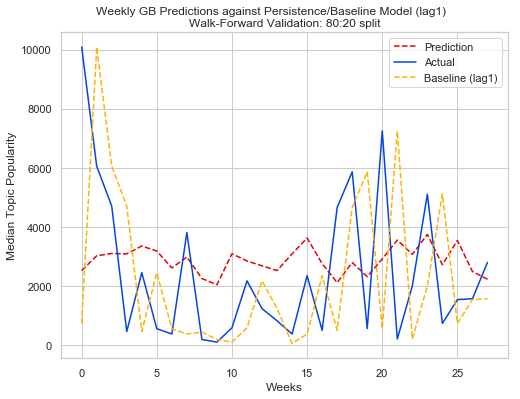

Topic: 150, Base RMSE: 1180.2559044546229, GB Model RMSE: 828.9474896123518, dMASE: 0.273
Topic: 149, Base RMSE: 3092.1909438670396, GB Model RMSE: 2007.6533122510918, dMASE: 0.305
Topic: 148, Base RMSE: 4897.40317088371, GB Model RMSE: 4014.294533293633, dMASE: -0.057
Topic: 147, Base RMSE: 2709.9672445744923, GB Model RMSE: 3237.9743196143404, dMASE: -0.052
Topic: 146, Base RMSE: 31168.547218900694, GB Model RMSE: 33918.29512012817, dMASE: 0.035
Topic: 145, Base RMSE: 6309.658703537633, GB Model RMSE: 5042.416887203117, dMASE: 0.164
Topic: 144, Base RMSE: 2951.051003679162, GB Model RMSE: 2160.1555541627813, dMASE: 0.359
Topic: 143, Base RMSE: 6359.734155869515, GB Model RMSE: 4606.270311264899, dMASE: 0.21
Topic: 142, Base RMSE: 3453.194245912037, GB Model RMSE: 2592.800258490865, dMASE: 0.311
Topic: 141, Base RMSE: 4678.425437198777, GB Model RMSE: 3275.4210939158324, dMASE: 0.267
Topic: 140, Base RMSE: 5015.651623613771, GB Model RMSE: 3151.863834749527, dMASE: 0.205
Topic: 139, B

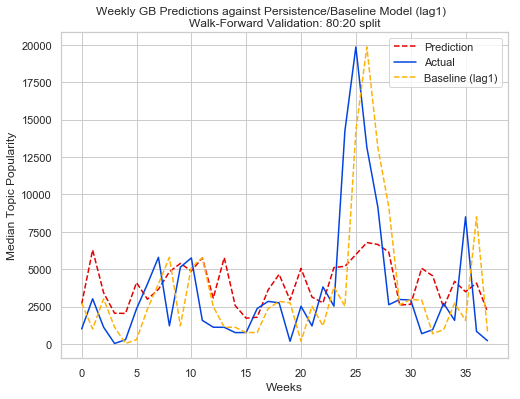

Topic: 135, Base RMSE: 2808.8028455197777, GB Model RMSE: 2258.2576766993416, dMASE: 0.104
Topic: 133, Base RMSE: 1895.282216075334, GB Model RMSE: 1521.0998623772698, dMASE: 0.079
Topic: 132, Base RMSE: 8289.696287889838, GB Model RMSE: 6139.426148289247, dMASE: 0.313
Topic: 131, Base RMSE: 1201.1101035164222, GB Model RMSE: 1039.8601691537128, dMASE: -0.083
Topic: 130, Base RMSE: 5106.743998508673, GB Model RMSE: 3812.870639247069, dMASE: 0.246
Topic: 129, Base RMSE: 3536.5011910670414, GB Model RMSE: 2974.842254247704, dMASE: 0.105
Topic: 128, Base RMSE: 2787.0603043787737, GB Model RMSE: 2105.5205994063235, dMASE: 0.045
Topic: 127, Base RMSE: 5762.908003010528, GB Model RMSE: 4471.146238319578, dMASE: 0.269
Topic: 126, Base RMSE: 3225.8326831997965, GB Model RMSE: 2593.7411023359246, dMASE: -0.005
Topic: 125, Base RMSE: 3772.400372862182, GB Model RMSE: 2302.0360309609646, dMASE: 0.393
Topic: 124, Base RMSE: 3445.7908706651037, GB Model RMSE: 3171.012574142015, dMASE: -0.171
Topic:

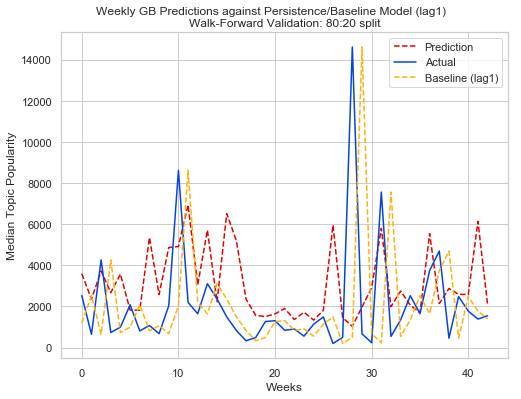

Topic: 120, Base RMSE: 1586.8355633975304, GB Model RMSE: 1311.3212012389286, dMASE: 0.146
Topic: 119, Base RMSE: 3047.7899701883907, GB Model RMSE: 2079.3384429442567, dMASE: 0.31
Topic: 118, Base RMSE: 3981.248749607339, GB Model RMSE: 2782.3770409437448, dMASE: 0.313
Topic: 117, Base RMSE: 1855.7185430381435, GB Model RMSE: 1619.797669648433, dMASE: -0.107
Topic: 116, Base RMSE: 5784.019879827359, GB Model RMSE: 3945.338846550437, dMASE: 0.387
Topic: 115, Base RMSE: 4005.2426978586454, GB Model RMSE: 2489.6726234033968, dMASE: 0.377
Topic: 114, Base RMSE: 4726.724135757825, GB Model RMSE: 3880.996098588842, dMASE: 0.17
Topic: 113, Base RMSE: 1433.3947855043673, GB Model RMSE: 1010.3505478327706, dMASE: 0.173
Topic: 112, Base RMSE: 2335.3145270428545, GB Model RMSE: 1976.861214196087, dMASE: 0.059
Topic: 111, Base RMSE: 4950.866467505437, GB Model RMSE: 3543.323793403224, dMASE: 0.188
Topic: 110, Base RMSE: 3394.0808025005003, GB Model RMSE: 2959.7092199164526, dMASE: 0.249
Topic: 10

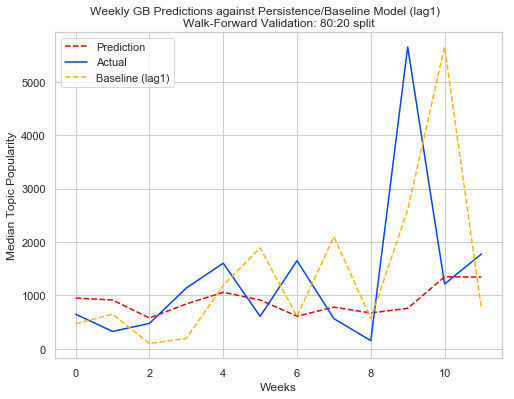

Topic: 105, Base RMSE: 2669.9317382995932, GB Model RMSE: 2136.716614127004, dMASE: -0.066
Topic: 104, Base RMSE: 4952.323131739567, GB Model RMSE: 3177.352358024244, dMASE: 0.283
Topic: 103, Base RMSE: 5328.8424692891795, GB Model RMSE: 5224.850318754292, dMASE: 0.199
Topic: 102, Base RMSE: 1913.6464490973397, GB Model RMSE: 1658.7728981923774, dMASE: 0.024
Topic: 101, Base RMSE: 3258.829687867074, GB Model RMSE: 2977.623916730152, dMASE: 0.192
Topic: 100, Base RMSE: 4178.8707688129125, GB Model RMSE: 3293.9801308630067, dMASE: 0.116
Topic: 99, Base RMSE: 6843.284433836672, GB Model RMSE: 4939.343275304984, dMASE: 0.253
Topic: 98, Base RMSE: 2459.5355794675274, GB Model RMSE: 2181.9483701366466, dMASE: 0.041
Topic: 97, Base RMSE: 2309.2116770544108, GB Model RMSE: 2148.864104993608, dMASE: 0.093
Topic: 96, Base RMSE: 4034.454585733718, GB Model RMSE: 3080.4360589667167, dMASE: 0.216
Topic: 95, Base RMSE: 1579.2872357734432, GB Model RMSE: 1253.0580796910203, dMASE: 0.068
Topic: 94, Ba

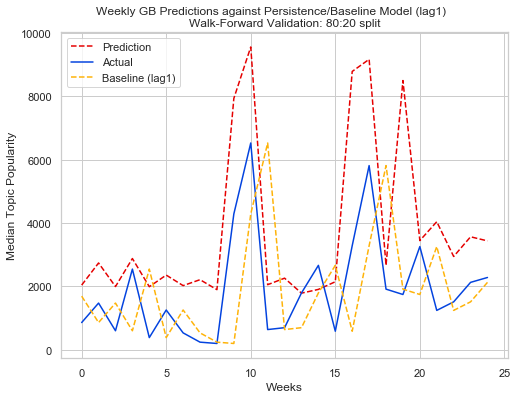

Topic: 90, Base RMSE: 3184.8354312488314, GB Model RMSE: 2210.578084431284, dMASE: 0.386
Topic: 89, Base RMSE: 2499.6074706993013, GB Model RMSE: 2136.806873720381, dMASE: -0.11
Topic: 88, Base RMSE: 2394.0230131517114, GB Model RMSE: 1869.035227927891, dMASE: 0.181
Topic: 87, Base RMSE: 1367.689724803595, GB Model RMSE: 1269.85202815169, dMASE: -0.13
Topic: 86, Base RMSE: 6127.870609967217, GB Model RMSE: 4069.7070681484565, dMASE: 0.221
Topic: 85, Base RMSE: 3591.0513664756545, GB Model RMSE: 2554.9154346960954, dMASE: 0.296
Topic: 84, Base RMSE: 3247.9999780084445, GB Model RMSE: 3543.1552172938755, dMASE: -0.332
Topic: 83, Base RMSE: 1592.334412249758, GB Model RMSE: 1652.8852034873676, dMASE: -0.065
Topic: 82, Base RMSE: 10518.321067577523, GB Model RMSE: 7087.06700158416, dMASE: 0.136
Topic: 81, Base RMSE: 12589.91608244324, GB Model RMSE: 7734.279517003774, dMASE: 0.278
Topic: 80, Base RMSE: 4713.543164021192, GB Model RMSE: 3104.8025452352636, dMASE: 0.335
Topic: 79, Base RMSE:

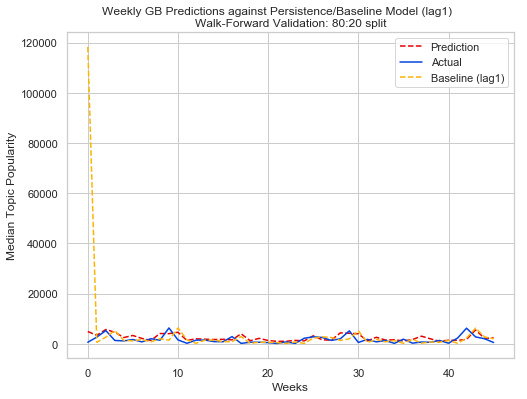

Topic: 76, Base RMSE: 2022.1908306476805, GB Model RMSE: 1543.444142573183, dMASE: 0.22


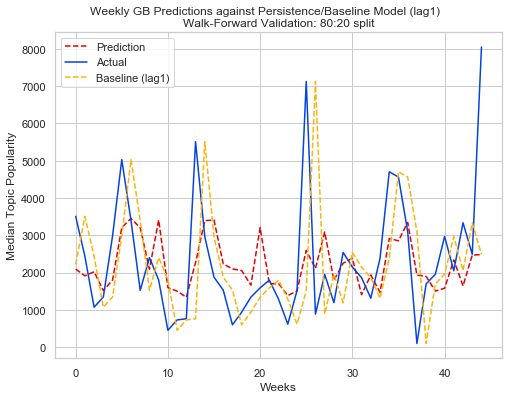

Topic: 75, Base RMSE: 2434.6344281596957, GB Model RMSE: 1825.852338036639, dMASE: 0.154
Topic: 74, Base RMSE: 13424.57948199096, GB Model RMSE: 11384.392881521675, dMASE: 0.167
Topic: 73, Base RMSE: 12504.820714274709, GB Model RMSE: 12218.029520219117, dMASE: 0.103
Topic: 72, Base RMSE: 1756.5351387746275, GB Model RMSE: 1756.5092104932794, dMASE: 0.023
Topic: 71, Base RMSE: 5499.013855315549, GB Model RMSE: 3689.5043914719345, dMASE: 0.4
Topic: 70, Base RMSE: 4002.6330894720004, GB Model RMSE: 2681.4433303979267, dMASE: 0.287
Topic: 69, Base RMSE: 3415.1462982771855, GB Model RMSE: 2205.1737734025533, dMASE: 0.361
Topic: 68, Base RMSE: 2045.067129418931, GB Model RMSE: 1404.1755750756433, dMASE: 0.252
Topic: 67, Base RMSE: 2517.2893888111626, GB Model RMSE: 2140.825801524867, dMASE: 0.166
Topic: 66, Base RMSE: 2805.1473403996715, GB Model RMSE: 3172.5077322131115, dMASE: 0.109
Topic: 65, Base RMSE: 3471.562678571424, GB Model RMSE: 2603.573639633709, dMASE: 0.262
Topic: 64, Base RMS

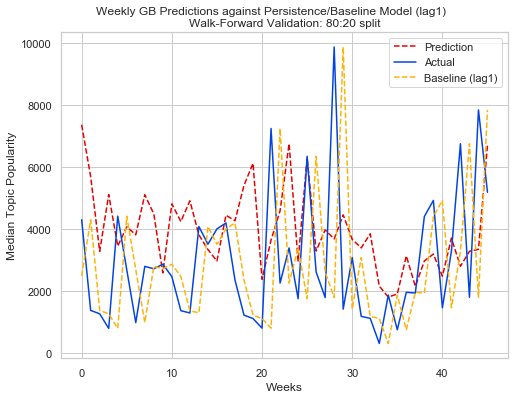

Topic: 60, Base RMSE: 4347.465439069348, GB Model RMSE: 3535.918719636157, dMASE: 0.059
Topic: 59, Base RMSE: 2110.3043206090906, GB Model RMSE: 1806.0905719251627, dMASE: 0.167
Topic: 58, Base RMSE: 3397.102873395569, GB Model RMSE: 2274.9323918093787, dMASE: 0.327
Topic: 57, Base RMSE: 1942.6722794970633, GB Model RMSE: 1404.1893648674188, dMASE: 0.171
Topic: 56, Base RMSE: 1957.1062898478215, GB Model RMSE: 1476.5548592910627, dMASE: 0.229
Topic: 55, Base RMSE: 2732.67456580704, GB Model RMSE: 1948.6429909921833, dMASE: 0.268
Topic: 54, Base RMSE: 9017.915338061477, GB Model RMSE: 6194.964001646889, dMASE: 0.327
Topic: 53, Base RMSE: 2313.6400385059424, GB Model RMSE: 1648.276437081392, dMASE: 0.274
Topic: 52, Base RMSE: 3739.7324550515445, GB Model RMSE: 2439.2279448808595, dMASE: 0.263
Topic: 51, Base RMSE: 7714.475400383684, GB Model RMSE: 12183.358654054256, dMASE: -0.248
Topic: 50, Base RMSE: 3544.965484632261, GB Model RMSE: 3075.1754354157374, dMASE: 0.182
Topic: 49, Base RMS

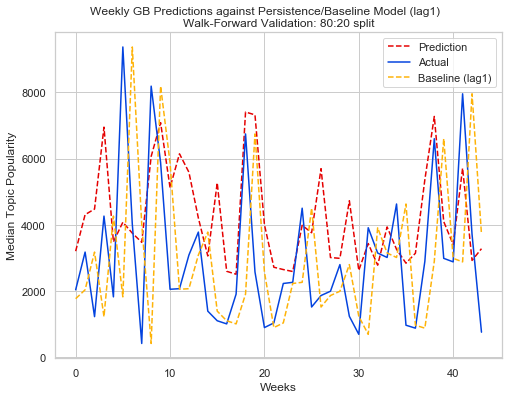

Topic: 45, Base RMSE: 10249.22366328299, GB Model RMSE: 8192.914372035626, dMASE: 0.313
Topic: 44, Base RMSE: 5302.688036731334, GB Model RMSE: 4090.810232043384, dMASE: 0.245
Topic: 43, Base RMSE: 3842.592276206622, GB Model RMSE: 2679.530270285256, dMASE: 0.24
Topic: 42, Base RMSE: 6966.41011688708, GB Model RMSE: 5460.93414036575, dMASE: 0.167
Topic: 41, Base RMSE: 2193.462114113812, GB Model RMSE: 1638.215262482709, dMASE: 0.203
Topic: 40, Base RMSE: 2388.7647599902816, GB Model RMSE: 1461.6507898983275, dMASE: 0.359
Topic: 39, Base RMSE: 2602.323615322206, GB Model RMSE: 2052.700338265467, dMASE: 0.102
Topic: 38, Base RMSE: 1977.2136463193576, GB Model RMSE: 1455.1483004615861, dMASE: 0.248
Topic: 37, Base RMSE: 8661.405824114236, GB Model RMSE: 5563.86030098925, dMASE: 0.417
Topic: 36, Base RMSE: 15368.161749001676, GB Model RMSE: 10777.957148604737, dMASE: 0.235
Topic: 35, Base RMSE: 3640.99357084393, GB Model RMSE: 2539.88078199078, dMASE: 0.208
Topic: 34, Base RMSE: 2937.51872

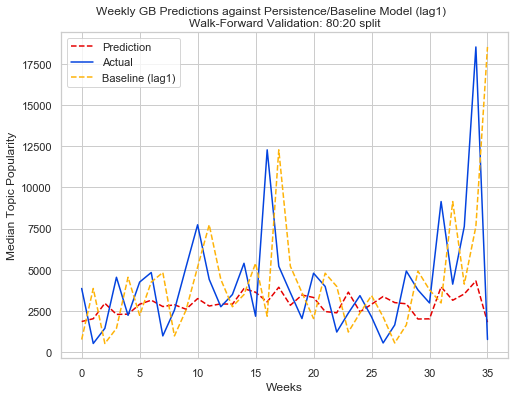

Topic: 30, Base RMSE: 3730.4014927183107, GB Model RMSE: 2498.8261680047453, dMASE: 0.33
Topic: 29, Base RMSE: 3543.05062763715, GB Model RMSE: 2401.033081490308, dMASE: 0.239
Topic: 28, Base RMSE: 1798.9197921947493, GB Model RMSE: 1622.2964092173308, dMASE: -0.046
Topic: 27, Base RMSE: 2672.2851846228064, GB Model RMSE: 2200.636368536116, dMASE: 0.092
Topic: 26, Base RMSE: 1907.4674964465319, GB Model RMSE: 1442.9606677438992, dMASE: 0.269
Topic: 25, Base RMSE: 2744.8030712603045, GB Model RMSE: 1665.4691900540895, dMASE: 0.376
Topic: 24, Base RMSE: 3411.367111793829, GB Model RMSE: 2477.676756191582, dMASE: 0.139
Topic: 23, Base RMSE: 3476.799597970013, GB Model RMSE: 2789.0520604757417, dMASE: 0.228
Topic: 22, Base RMSE: 3276.849298314409, GB Model RMSE: 2146.5037890257518, dMASE: 0.208
Topic: 21, Base RMSE: 3903.3361712290425, GB Model RMSE: 3083.77064803283, dMASE: 0.137
Topic: 20, Base RMSE: 3296.382605184341, GB Model RMSE: 2206.628984488596, dMASE: 0.327
Topic: 19, Base RMSE: 

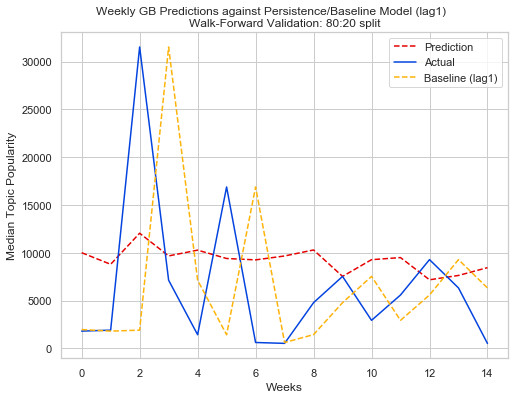

Topic: 15, Base RMSE: 2614.23373444164, GB Model RMSE: 2931.5077038232785, dMASE: -0.222
Topic: 14, Base RMSE: 1358.1372824228692, GB Model RMSE: 1007.3164346208239, dMASE: 0.244
Topic: 13, Base RMSE: 5585.913445600382, GB Model RMSE: 4055.9789934182922, dMASE: 0.191
Topic: 12, Base RMSE: 3140.3048116039004, GB Model RMSE: 2321.59987516273, dMASE: 0.284
Topic: 11, Base RMSE: 3178.5127375592015, GB Model RMSE: 2202.3316175253703, dMASE: 0.171
Topic: 10, Base RMSE: 4189.674433311359, GB Model RMSE: 3227.2105188739088, dMASE: 0.279
Topic: 9, Base RMSE: 5736.165976188536, GB Model RMSE: 6025.502630847341, dMASE: 0.145
Topic: 8, Base RMSE: 4153.003969187256, GB Model RMSE: 2663.1682821064296, dMASE: 0.359
Topic: 7, Base RMSE: 3843.5472292624986, GB Model RMSE: 3908.994303053504, dMASE: -0.231
Topic: 6, Base RMSE: 2451.857318669076, GB Model RMSE: 1848.9467137252072, dMASE: 0.15
Topic: 5, Base RMSE: 1542.3943237706758, GB Model RMSE: 1087.78171049409, dMASE: 0.322
Topic: 4, Base RMSE: 4130.0

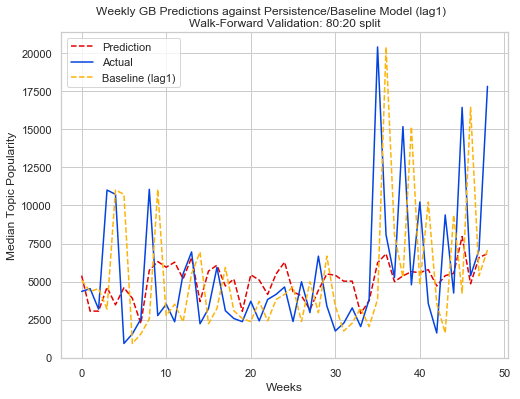

In [17]:
# Unoptimized Gradient Boosting
summary_df, all_predictions = comp_ts_modelling(model_name='gb', model_tuning=False, 
                                                data=data, grid_frac=0, plot_freq=25)

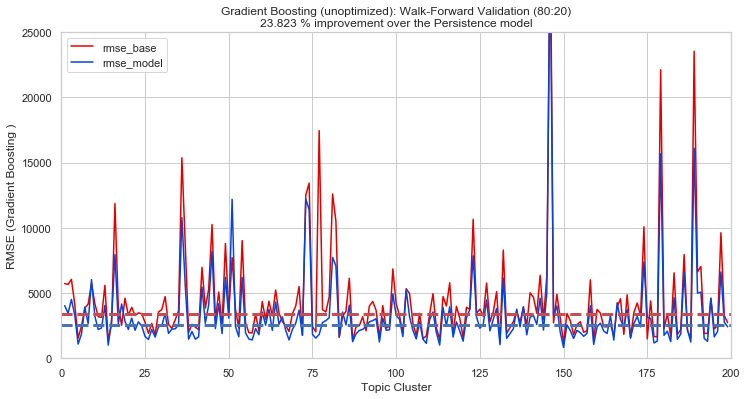

In [26]:
ax = plt.subplot(111)
summary_df.set_index('ntopic')[['rmse_base', 'rmse_model']]\
                    .plot(ax=ax, logy=False, ylim=(0, 25000),
                         figsize=(12, 6), xlim=(0,200))
    
rbase = summary_df['rmse_base'].median()
rmodel = summary_df['rmse_model'].median()
plt.plot([0, 200], [rbase, rbase], 'r--', lw=3)
plt.plot([0, 200], [rmodel, rmodel], 'b--', lw=3)
plt.xlabel("Topic Cluster")
plt.ylabel('RMSE (Gradient Boosting )')
title = 'Gradient Boosting (unoptimized): Walk-Forward Validation (80:20)\n'+ str(round(((summary_df.rmse_base - summary_df.rmse_model)/\
      summary_df.rmse_base).median()*100, 3))+' % improvement over the Persistence model'
plt.title(title);

### Hyperparameter Tuning: 

Both unoptimized gradient boosting and Random Forests performed worse than simple Ridge Regression. There are around 5 major parameters in the grid that need tuning. These k=5 parameters have a total of n=18 values I am interested in exploring. Sampling 5 elements at each step from 18 different values translates to: 18!/5! * (18-5)! = 8568 combinations. Fortunately, we aren't actually sampling from a population of 18 elements as each of the 5 classes have only have a subset of elements to choose from:

In [53]:
grid = {'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        "max_depth":[3, 5, 7, None],
        "n_estimators":[100, 250, 500, 750, 1000, 1250, 1500]} 
from sklearn.model_selection import ParameterGrid
print("That's a total of {} grids!".format(len(list(ParameterGrid(grid)))))

That's a total of 504 grids!


That is, I'll need to explore 504 grids PER topic followed by one-step walk-forward validation on 80:20 split validation data! That takes quite a bif of time. I need to randomly sub-sample the gridspace. RandomGridCV on sklearn doesn't account for temporal dependency in sequencial data that requires one-step walk-forward validation. So, implemented random sampling without replacement from the ParameterGrid for downstream model fitting and WF validation.

In [ ]:
# Run Random Forests (WITH hyperparameter tuning: random sampling 20% gridspace without replacement)
summary_df, all_predictions = comp_ts_modelling(model_name='rf', model_tuning=True, 
                                                data=data, grid_frac=0.2, plot_freq=25)

Tuning hyperparameters for RF. Randomly sampling 36 grids..

Topic: 199, RF Best RMSE: 2395.2636474538085, Best dMASE: -0.02	 Grid: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuning hyperparameters for RF. Randomly sampling 36 grids..

Topic: 198, RF Best RMSE: 2825.566593795506, Best dMASE: 0.192	 Grid: {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Tuning hyperparameters for RF. Randomly sampling 36 grids..

Topic: 197, RF Best RMSE: 6302.078181395659, Best dMASE: 0.195	 Grid: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Tuning hyperparameters for RF. Randomly sampling 36 grids..

Topic: 196, RF Best RMSE: 1928.3407087628143, Best dMASE: 0.027	 Grid: {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Tuning hyperparameters for RF. Ra

### Deep Time-series Learning: LSTM

In [ ]:
# Watch this space.

In [ ]:
# Containers for storing performance metrics for all topics
tmp_topic, tmp_model_params = [], []
tmp_dmase, tmp_rmse_base, tmp_rmse_model  = [], [], []
all_predictions = pd.DataFrame()

# Time-series modeling for all topics
alltopics = data['predicted_topic'].unique()
alltopics = sorted(alltopics, reverse=True)
for ntopic in alltopics:
    try:
        # Prepare data and engineer lag for timeseries analysis:
        X = ts_preprocess(data, ntopic, metric='likes', sampling='W-MON', view_corr=False)

        if model_tuning: # Hyperparameter search:
                model_params = model_hp_tuning(X, model_name, ntopic, metric='likes', 
                                               grid_frac=grid_frac, verbose=False)
        else: # default parameters
            if model_name == 'gb':
                model_params = {'n_estimators':1000, 'learning_rate':0.001}

            elif model_name == 'rf':
                model_params = {'n_estimators':1000, 'n_jobs':-1, 'random_state':1}

            elif model_name == 'arima':
                # ts_model = model_arima()
                print("ARIMA will be made available soon.")
                break

            elif model_name == 'lstm':
                # ts_model = model_lstm()
                print("LSTM will be made available soon.")
                break

            else:
                print("Model not selected.")
                break

        # Switch plotting on for every nth topic fit:
        if ntopic in list(range(1, max(alltopics), plot_freq)):
            plot_ = True
        else:
            plot_ = False

        # Fit model:
        temp_pred_df, rmse_base, rmse_model, dmase = \
                            ts_ensemble(X, model_name, model_params, 
                            ntopic=ntopic, metric='likes', plot_=plot_)

        # Concatenate (row-wise) predicted values df for each topic 
        all_predictions = pd.concat([all_predictions, temp_pred_df],axis=0, ignore_index=False)

        # Collect summary data for all topics
        tmp_topic.append(ntopic)
        tmp_rmse_base.append(rmse_base)
        tmp_rmse_model.append(rmse_model)
        tmp_dmase.append(dmase)
        tmp_model_params.append(model_params)

    except IndexError:
        print(ntopic ," not found in the collection of topics")
        pass

# Create a summary df for all performance metrics
summary_df = pd.DataFrame()
summary_df['ntopic'] = tmp_topic
summary_df['rmse_base'] = tmp_rmse_base
summary_df['rmse_model'] = tmp_rmse_model
summary_df['dmase'] = tmp_dmase
summary_df['model'] = model_name
summary_df['hp_tuning'] = str(model_tuning)
#     summary_df['model_params'] = str(tmp_model_params) 

# Save predictions and prediction metrics to file:
fname = str(model_name)+'_hptuning='+str(model_tuning)+\
        '_nmf_ntopics='+str(round(len(data['predicted_topic'].unique())))
summary_df.to_parquet('data/ts_predictions/pred_summary_ts_'+fname+'.parquet', engine='pyarrow')

all_predictions.to_parquet('data/ts_predictions/all_preds_ts_'+fname+'.parquet', engine='pyarrow')

# Save all predictions to JSON for compatbility with Tableau if needed.
all_predictions.reset_index(drop=False).to_json('data/ts_predictions/all_preds_ts_'+fname+'.json', orient='index')

return summary_df, all_predictions